# 03_clustering_analyses

## Выводы

- чистые embeddings дают плохие метрики по класстеризации
- добавление числовых фичей улучшают метрики класстеризации, но когда просматривается в ручную  результата, нет ощущения, что кластеризация сделана качественно
- дальнейшие возможные шаги:
  - сделать tf idf для  биграм, триграм и 4 грамм
  - применить топик моделирование

-  на графиках видно, что ембеддинги без числовых фичах хорошо размечаются как k-mean. Это видно как не tsne, так и на pca.  Видно что с числовыми фичами большинство размечается одним классом.

## Plan

- k-means for embeddings, choose the best
- k-means - n clusters - метод локтя
- k-means - всевозможные метрики
- k-means draw embeddings with T-SNE
- k-means draw embeddings with PCA
- k-means - top words

- k-means for embeddings + num_features, choose the best

- Agglomerative Clustering
- DBSCAN

- Разметка для модели
  

## Imports

In [13]:
import numpy as np
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from itertools import chain

## Initialization

In [14]:
pd.set_option("display.max_colwidth", None)

plt.style.use("classic")
# Ignore UserWarning specifically
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["OMP_NUM_THREADS"] = "2"

In [15]:
PROJECT_NAME = "finam_text_classification"
FILE_INPUT_NAME = "all_embeddings.parquet"

# Get the current working directory
current_dir = Path.cwd()


# Traverse up to find "finam_text_classification" folder
project_root = current_dir
while project_root.name != PROJECT_NAME:
    if project_root.parent == project_root:  # Reached the filesystem root
        raise FileNotFoundError("The 'finam_text_classification' folder was not found.")
    project_root = project_root.parent

# Define the path to the input data relative to the project root
PTH_TO_INPUT_DATA = project_root / "data" / "interim" / FILE_INPUT_NAME

## Main pipeline

### Read data

In [16]:
# Read data
try:
    # Use Path to check if the file exists
    if PTH_TO_INPUT_DATA.exists():
        # Read the Excel file
        df_init = pd.read_parquet(PTH_TO_INPUT_DATA)
        logging.info("File successfully loaded.")
    else:
        # Log an error if the file is not found
        logging.error(f"File not found: {PTH_TO_INPUT_DATA}")
except Exception as e:
    # Log any exceptions that occur
    logging.error(f"An error occurred: {e}")

In [17]:
df_init.head(1).T

,0
review_id,1
review_text,Элегантный отель в самом центре Дубай. Красивые и стильные номера. И жуткие цены) До посещения отеля рекомендуется ограбить банк или неожиданно разбогатеть)))Это пишу чтобы набрать 200 символов))))))
normalized_review_text,элегантный отель центр <loc> красивый стильный номер жуткий цена посещение отель рекомендоваться ограбить банк неожиданно разбогатеть это писать набрать <num> символ
loc_count,1
org_count,0
misc_count,0
per_count,0
right_parenthesis_cnt,10
left_parenthesis_cnt,0
point_cnt,2


In [18]:
df_init.columns

Index(['review_id', 'review_text', 'normalized_review_text', 'loc_count',
       'org_count', 'misc_count', 'per_count', 'right_parenthesis_cnt',
       'left_parenthesis_cnt', 'point_cnt', 'comma_cnt', 'exlaim_cnt',
       'num_cnt', 'len_in_symbols', 'len_in_words', 'avr_len_words',
       'encode_5', 'encode_10', 'encode_100', 'encode_500',
       'filtered_norm_text_5', 'filtered_norm_text_10',
       'filtered_norm_text_100', 'filtered_norm_text_500', 'tfidf_vector_5',
       'tfidf_vector_10', 'tfidf_vector_100', 'tfidf_vector_500',
       'fasttext_vector_5', 'fasttext_vector_10', 'fasttext_vector_100',
       'fasttext_vector_500', 'rubert_tiny_vector_5', 'rubert_tiny_vector_10',
       'rubert_tiny_vector_100', 'rubert_tiny_vector_500',
       'sbert_large_vector_5', 'sbert_large_vector_10',
       'sbert_large_vector_100', 'sbert_large_vector_500'],
      dtype='object')

In [19]:
ls_embedings = [
    "tfidf_vector_5",
    "tfidf_vector_10",
    "tfidf_vector_100",
    "tfidf_vector_500",
    "fasttext_vector_5",
    "fasttext_vector_10",
    "fasttext_vector_100",
    "fasttext_vector_500",
    "rubert_tiny_vector_5",
    "rubert_tiny_vector_10",
    "rubert_tiny_vector_100",
    "rubert_tiny_vector_500",
    "sbert_large_vector_5",
    "sbert_large_vector_10",
    "sbert_large_vector_100",
    "sbert_large_vector_500",
]

## k-means for only embeddings

- выберим лучшие ембеддинги

In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

for embed_name in ls_embedings:

    embeddings = np.array(df_init[embed_name].to_list())
    # K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    clusters_kmeans = kmeans.fit_predict(embeddings)
    silhouette = silhouette_score(embeddings, clusters_kmeans)
    calinski_harabasz = calinski_harabasz_score(embeddings, clusters_kmeans)
    davies_bouldin = davies_bouldin_score(embeddings, clusters_kmeans)

    print("*" * 20)
    print(f"Название эмбеддинга: {embed_name}")
    print(f"Силуэтный коэффициент: {silhouette:.2f} (стремление у 1 лучше)")
    print(f"Коэффициент Калински-Харабаса: {calinski_harabasz:.2f} (выше лучше)")
    print(f"Индекс Дэвиса-Болдина: {davies_bouldin:.2f} (меньше лучше)")

********************
Название эмбеддинга: tfidf_vector_5
Силуэтный коэффициент: 0.00 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 44.14 (выше лучше)
Индекс Дэвиса-Болдина: 11.85 (меньше лучше)
********************
Название эмбеддинга: tfidf_vector_10
Силуэтный коэффициент: 0.00 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 46.87 (выше лучше)
Индекс Дэвиса-Болдина: 11.49 (меньше лучше)
********************
Название эмбеддинга: tfidf_vector_100
Силуэтный коэффициент: 0.01 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 74.13 (выше лучше)
Индекс Дэвиса-Болдина: 9.17 (меньше лучше)
********************
Название эмбеддинга: tfidf_vector_500
Силуэтный коэффициент: 0.02 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 174.07 (выше лучше)
Индекс Дэвиса-Болдина: 6.01 (меньше лучше)
********************
Название эмбеддинга: fasttext_vector_5
Силуэтный коэффициент: 0.07 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 454.66 (выше лучше)
Индекс Дэвиса-Болдина: 3.7

**Вывод:**

самый лучшие результат показали embeddings:

- Название эмбеддинга: rubert_tiny_vector_5
- Силуэтный коэффициент: 0.12 (стремление к 1 лучше)
- Коэффициент Калински-Харабаса: 947.03 (выше лучше)
- Индекс Дэвиса-Болдина: 2.25 (меньше лучше)

## k-means for only numerical feats

In [21]:
from sklearn.preprocessing import StandardScaler

df_init["concatenated_num_feats"] = df_init[
    [
        "loc_count",
        "org_count",
        "misc_count",
        "per_count",
        "right_parenthesis_cnt",
        "left_parenthesis_cnt",
        "point_cnt",
        "comma_cnt",
        "exlaim_cnt",
        "num_cnt",
        "len_in_symbols",
        "len_in_words",
        "avr_len_words",
    ]
].apply(lambda row: np.concatenate([np.array([col]) for col in row], axis=0), axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_init["concatenated_num_feats"].to_list())

In [22]:
scaled_features[:3]

array([[-0.40845365, -0.24723352, -0.74203329, -0.37281513,  3.68275533,
        -0.49805932, -0.7423411 , -0.7423411 , -0.2299239 , -0.12958397,
        -0.70316982, -0.69355732,  0.11770287],
       [ 2.07111726,  1.69559809,  1.30267185, -0.37281513,  0.76818432,
         0.19197813,  0.93859726,  0.93859726, -0.2299239 ,  0.29552068,
         1.5956822 ,  1.62928758, -0.17090767],
       [-0.40845365, -0.24723352, -0.74203329, -0.37281513, -0.48091754,
        -0.49805932,  0.0420968 ,  0.0420968 , -0.2299239 , -0.55468862,
        -0.34950028, -0.29535534, -0.19085347]])

In [23]:
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(scaled_features)
silhouette = silhouette_score(scaled_features, clusters_kmeans)
calinski_harabasz = calinski_harabasz_score(scaled_features, clusters_kmeans)
davies_bouldin = davies_bouldin_score(scaled_features, clusters_kmeans)

print("*" * 20)
print(f"Числовые фичи")
print(f"Силуэтный коэффициент: {silhouette:.2f} (стремление у 1 лучше)")
print(f"Коэффициент Калински-Харабаса: {calinski_harabasz:.2f} (выше лучше)")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin:.2f} (меньше лучше)")

********************
Числовые фичи
Силуэтный коэффициент: 0.61 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 2378.98 (выше лучше)
Индекс Дэвиса-Болдина: 1.20 (меньше лучше)


**Вывод:**

числовые фичи дают значительно лучший результат, чем эмбеддинги:

- Числовые фичи
- Силуэтный коэффициент: 0.61 (стремление у 1 лучше)
- Коэффициент Калински-Харабаса: 2378.98 (выше лучше)
- Индекс Дэвиса-Болдина: 1.20 (меньше лучше)

### k-means with numerical features and embeddings

In [24]:
from sklearn.preprocessing import normalize

# Нормализуем эмбеддинги по L2
normalized_embeddings = normalize(embeddings, norm="l2")

In [25]:
import numpy as np

# Объединяем нормализованные эмбеддинги и масштабированные числовые признаки
combined_features = np.hstack((normalized_embeddings, scaled_features))
normalized_embeddings[1].shape, scaled_features[1].shape, combined_features[1].shape

((1024,), (13,), (1037,))

In [26]:
# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(combined_features)
silhouette = silhouette_score(combined_features, clusters_kmeans)
calinski_harabasz = calinski_harabasz_score(combined_features, clusters_kmeans)
davies_bouldin = davies_bouldin_score(combined_features, clusters_kmeans)

print("*" * 20)
print(f"Числовые фичи + ембеддинги")
print(f"Силуэтный коэффициент: {silhouette:.2f} (стремление у 1 лучше)")
print(f"Коэффициент Калински-Харабаса: {calinski_harabasz:.2f} (выше лучше)")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin:.2f} (меньше лучше)")

********************
Числовые фичи + ембеддинги
Силуэтный коэффициент: 0.60 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 2315.54 (выше лучше)
Индекс Дэвиса-Болдина: 1.22 (меньше лучше)


**Вывод:**

числовые фичи + эмбеддинги примерно тоже самое, что просто числовые фичи:

- Числовые фичи + эмбеддинги
- Силуэтный коэффициент: 0.60 (стремление у 1 лучше)
- Коэффициент Калински-Харабаса: 2315.54 (выше лучше)
- Индекс Дэвиса-Болдина: 1.22 (меньше лучше)

## Подбор числа кластеров k-means по методу локтя

Суть метода
Метод основан на анализе зависимости между количеством кластеров 
𝑘
k и метрикой качества кластеризации, например:

WSS (Within-Cluster Sum of Squares) — сумма квадратов расстояний между точками и центроидами их кластеров.
Основная идея
При увеличении количества кластеров:

WSS (или аналогичная метрика) уменьшается, так как больше кластеров лучше описывают данные.
Однако уменьшение WSS замедляется по мере увеличения 
𝑘
k.
Оптимальное количество кластеров определяется как точка на графике, где происходит "излом" (локоть). Это точка, после которой добавление новых кластеров даёт незначительное улучшение качества.


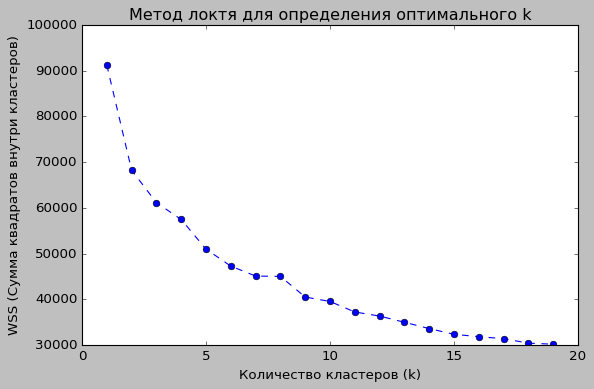

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

X = combined_features

# Диапазон количества кластеров
k_values = range(1, 20)
wss = []  # Здесь будут значения WSS

# Расчёт WSS для каждого значения k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)  # inertia_ — это WSS в sklearn

# Построение графика
plt.figure(figsize=(8, 5))
plt.plot(k_values, wss, marker="o", linestyle="--", color="b")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("WSS (Сумма квадратов внутри кластеров)")
plt.title("Метод локтя для определения оптимального k")
plt.show()

Вывод: оптимальное число кластеров 7-8 

In [28]:
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_kmeans_all_feats = kmeans.fit_predict(combined_features)
silhouette = silhouette_score(combined_features, clusters_kmeans_all_feats)
calinski_harabasz = calinski_harabasz_score(combined_features, clusters_kmeans_all_feats)
davies_bouldin = davies_bouldin_score(combined_features, clusters_kmeans_all_feats)

print("*" * 20)
print(f"Числовые фичи + ембеддинги")
print(f"Силуэтный коэффициент: {silhouette:.2f} (стремление у 1 лучше)")
print(f"Коэффициент Калински-Харабаса: {calinski_harabasz:.2f} (выше лучше)")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin:.2f} (меньше лучше)")

********************
Числовые фичи + ембеддинги
Силуэтный коэффициент: 0.32 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 1205.23 (выше лучше)
Индекс Дэвиса-Болдина: 1.23 (меньше лучше)


In [29]:
embed_name = "rubert_tiny_vector_5"
embeddings = np.array(df_init[embed_name].to_list())

kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_kmeans_embed = kmeans.fit_predict(embeddings)
silhouette = silhouette_score(embeddings, clusters_kmeans_embed)
calinski_harabasz = calinski_harabasz_score(embeddings, clusters_kmeans_embed)
davies_bouldin = davies_bouldin_score(embeddings, clusters_kmeans_embed)

print("*" * 20)
print(f"ембеддинги")
print(f"Силуэтный коэффициент: {silhouette:.2f} (стремление у 1 лучше)")
print(f"Коэффициент Калински-Харабаса: {calinski_harabasz:.2f} (выше лучше)")
print(f"Индекс Дэвиса-Болдина: {davies_bouldin:.2f} (меньше лучше)")

********************
ембеддинги
Силуэтный коэффициент: 0.05 (стремление у 1 лучше)
Коэффициент Калински-Харабаса: 332.45 (выше лучше)
Индекс Дэвиса-Болдина: 3.73 (меньше лучше)


##  Самые часто встречающиеся слова в кластере

In [30]:
df_init["k_means_embed"] = clusters_kmeans_embed + 1
df_init["k_means_all_feats"] = clusters_kmeans_all_feats + 1

In [ ]:
from collections import Counter

msk_cls = df_init["k_means_embed"] == 1

ls_ls_words = list(map(str.split, df_init[msk_cls].normalized_review_text.to_list()))
ls_flt = list(chain(*ls_ls_words))
cnt = Counter(ls_flt)
cnt.most_common(15)
# list(chain(*(df_init[msk_cls].normalized_review_text.to_list())))

In [182]:
def get_most_common_words(
    df, column_words="normalized_review_text", column_cluster="k_means_embed", cluster_value=1, n=20
):

    mask = df[column_cluster] == cluster_value
    words_list = list(map(str.split, df[mask][column_words].to_list()))
    flattened_words = list(chain(*words_list))
    word_counts = Counter(flattened_words)

    return word_counts.most_common(n)

In [195]:
for i in range(1, 8):
    column_cluster = "k_means_embed"
    print("*" * 10)
    print("cluster = ", i, f" ; {column_cluster=}")
    print(get_most_common_words(df=df_init, column_cluster="k_means_embed", cluster_value=i))
    msk = df_init[column_cluster] == i
    display(df_init[msk]["review_text"].head(3))

**********
cluster =  1  ; column_cluster='k_means_embed'
[('<loc>', 1884), ('отель', 1392), ('очень', 865), ('номер', 756), ('<misc>', 738), ('весь', 670), ('персонал', 475), ('<num>', 454), ('хороший', 443), ('расположение', 351), ('центр', 285), ('это', 281), ('удобный', 279), ('отличный', 274), ('завтрак', 245), ('рядом', 242), ('город', 217), ('уютный', 206), ('понравиться', 204), ('место', 196)]


0                                                                                                                                                                                                                                                                                                                                                                       Элегантный отель в самом центре Дубай. Красивые и стильные номера. И жуткие цены) До посещения отеля рекомендуется ограбить банк или неожиданно разбогатеть)))Это пишу чтобы набрать 200 символов))))))
8                                                                                                                                                                                                                                                                                                                                                                                                                      Хороший отель. Для нас важно было

**********
cluster =  2  ; column_cluster='k_means_embed'
[('номер', 1291), ('отель', 999), ('очень', 961), ('<loc>', 782), ('<misc>', 733), ('весь', 655), ('завтрак', 562), ('хороший', 530), ('<num>', 527), ('это', 327), ('отличный', 300), ('персонал', 299), ('удобный', 281), ('расположение', 244), ('чистый', 234), ('комната', 230), ('рядом', 225), ('метро', 223), ('кровать', 213), ('маленький', 211)]


2     Провели с супругой там уик енд. Брали самый люкс с видом на фонтаны. Все было на уровне. Отличный панорамный вид на фонтаны. Номера шикарные просторные стильные. Во всем чувствуется качество и люкс. К номеру бесплатно предоставили бентли с водителем. Завтраки отличные , безупречное спа, прекрасный фитнес, во общем недостатков нет, кроме того что отель городской и моря рядом нет. Ну и маленький бассейн.
4                                                                                                                                                                                     меня впечатлили размеры! самый огромный номер, в котором я когда либо жил! отличное обслуживание! не понравился вид за окном, далековато от центра. в номерах очень сильное охлождение - можно и по мягче кондиционеры устанавливать.
38                                                                                                                                                            Пляж у отеля свой,

**********
cluster =  3  ; column_cluster='k_means_embed'
[('<loc>', 5674), ('<num>', 4996), ('отель', 4771), ('номер', 4072), ('<misc>', 3253), ('весь', 2846), ('очень', 2654), ('это', 2022), ('день', 1193), ('завтрак', 1096), ('хороший', 1061), ('<per>', 1006), ('который', 960), ('минута', 845), ('этаж', 783), ('метро', 780), ('персонал', 724), ('вид', 635), ('комната', 611), ('рядом', 611)]


1    Если стиль вашей поездки в Дубай-- это шоппинг в Дубай молле, созерцание фонтана и гастрономический ужин-- не пожалейте денег "усилить" все эти ощущения номером с видом на фонтан в отеле Armani. Это просто супер. Номера находятся на нижних этажах Burj Khalifa, поэтому вид на фонтан оттуда точно лучше, чем с улицы около, и даже лучше, чем с крыши этого замечательного здания. Лучше, чем из ресторана... В общем-- самый лучший. Я прямо будильник заводил и выходил смотреть фонтан на балкон (представления меняются в течение вечера). На балконах можно курить, что не может не радовать не расставшихся с этой привычкой. Но такие номера продают только на сайте самого отеля-- у перекупщиков типа booking.com их нет. В номере мы увидели реально работающий, удобный и функциональный "умный дом"-- управление всей электроникой номера с iPad mini. Дизайн-- не просто привлекательный и интересный, но и очень функциональный. Сервис-- честные 5* Grand Luxe, мальчик на этаже, любой вопрос решается момент

**********
cluster =  4  ; column_cluster='k_means_embed'
[('<loc>', 2054), ('отель', 1711), ('номер', 1389), ('<num>', 1152), ('очень', 1123), ('<misc>', 928), ('весь', 838), ('это', 513), ('хороший', 445), ('завтрак', 435), ('персонал', 380), ('минута', 350), ('метро', 330), ('день', 309), ('<per>', 298), ('рядом', 285), ('центр', 250), ('расположение', 248), ('удобный', 245), ('который', 243)]


3     По дороге домой для того, чтобы перекантоваться во время пересадки на рейс до МСк, и в качестве сюрприза для молодой жены был выбран именно этот отель. Списался с ними еще в Азии предупредил о сюрпризе. Все было организовано на высочайшем уровне, начиная с наших первых шагов в аэропорту. Так получилось, что забыл костюм в кабине самолета, наш встречающий в аэропорту от отеля сказал не париться и сам организовал и поиски, и доставку костюма в отель... Вез к отелю нас шикарный БЕНТЛИ, включено в стоимость номера, а в самом номере ждал сладкий сюрприз. Определенно - очень грамотно организованный персонал, прием и сам отель... При необходимости Ваш менеджер организует билеты со скидкой на экскурсию в башню на любое удобное для Вас время и расскажет/подскажет все что Вы хотите посмотреть в городе... Удачи и приятного отдыха...
41      Несомненным плюсом отеля является его расположение непосредственно на берегу. Отличная озелененная территория, множество пальм, кустов и т.д. Наличие ог

**********
cluster =  5  ; column_cluster='k_means_embed'
[('номер', 1110), ('<num>', 764), ('<misc>', 728), ('отель', 547), ('весь', 539), ('<loc>', 517), ('очень', 350), ('это', 329), ('день', 233), ('хороший', 207), ('завтрак', 207), ('персонал', 199), ('<per>', 175), ('цена', 160), ('ночь', 136), ('этаж', 130), ('гостиница', 128), ('расположение', 127), ('который', 124), ('останавливаться', 124)]


9     В отеле hawthorn suites JBR были с 1 по 6.02.17. Отель не соответствует уровню 4*. Сервис не очень хороший, уборка номеров - плохо! Мы были с семьёй - 4 взрослых. При заезде в номер было только 1 полотенце! Не отдельно для лица, рук, банное. А вообще одно! На второй день попросили поставить все на 4 человека, так и не дождались. В номер принесли только дополнительные халаты и так и не убрались. И только на 4 день проживания доставили все необходимое. Когда я попросила Мейл генерального менеджера. 
11                                                                                                                                                           До пляжа 7 минут, полотенца на пляж дают. Завтраки нормальные, вода в номере бесплатная.По сравнению с другим отелями в этом месте, этот достаточно скромный, но в целом к нему замечаний нет.Важно: при букировании онлайн в цену не входит налог за проживание, который составляет 15 AED за день.Сам район крайне приятный, поэтому в целом

**********
cluster =  6  ; column_cluster='k_means_embed'
[('отель', 1170), ('очень', 1076), ('номер', 785), ('весь', 685), ('персонал', 628), ('<loc>', 560), ('хороший', 509), ('<misc>', 412), ('завтрак', 382), ('отличный', 340), ('удобный', 254), ('расположение', 237), ('понравиться', 234), ('прекрасный', 221), ('спасибо', 213), ('чистый', 209), ('<num>', 207), ('уютный', 204), ('приятный', 189), ('ресторан', 181)]


7                                                                                                Хороший отель. Питание отличное. Хотя отель не старый, но требует ремота в ванных компатах. Было сыро, вещи не высыхали. 
10                                                                                        Номера очень просторные и красивый вид из окна.Большой плюс - это наличие Интернета в комнате.Хорошо провели время в этом отеле!
17    Потрясающий, восхитительный, роскошный, незабываемый отель! Все на высоте: персонал, сервис, еда!!! Большое количество ресторанов с различными кухнями мира!Прекрасный пляж!!! Большая территория!!!Всем рекомендую!
Name: review_text, dtype: object

**********
cluster =  7  ; column_cluster='k_means_embed'
[('<loc>', 2201), ('отель', 1156), ('номер', 1075), ('<num>', 872), ('очень', 728), ('метро', 709), ('<misc>', 694), ('рядом', 539), ('весь', 497), ('минута', 437), ('хороший', 370), ('центр', 336), ('завтрак', 311), ('расположение', 305), ('удобный', 282), ('это', 270), ('пешком', 270), ('расположить', 250), ('маленький', 230), ('персонал', 229)]


13                                                                                                                                                                                                                                                        Обслуживание отличное! Апартаменты просторные! Находится рядом с пляжем, что очень удобно и относительно недалеко от станции метро. Шумно при открытых окнах, но поскольку везде есть кондиционеры, это не проблема. Отель новый, в коридорах пахло краской, но думаю что со временем это пройдет! В остальном придирок нет, все на хорошем уровне!
24                                                                                                                                                                                                                                                                                                                                        В отеле НЕТ ГОРЯЧЕЙ ВОДЫ. Только холодная и очень холодная. Когда просишь вызват

In [197]:
for i in range(1, 8):
    column_cluster = "k_means_all_feats"
    print("*" * 10)
    print("cluster = ", i, f" ; {column_cluster=}")
    print(get_most_common_words(df=df_init, column_cluster=column_cluster, cluster_value=i))
    msk = df_init[column_cluster] == i
    display(df_init[msk]["review_text"].head(3).T)

**********
cluster =  1  ; column_cluster='k_means_all_feats'
[('<loc>', 4716), ('отель', 3751), ('<num>', 3604), ('номер', 3367), ('<misc>', 2730), ('очень', 2274), ('весь', 1981), ('это', 1357), ('хороший', 949), ('завтрак', 930), ('день', 807), ('метро', 757), ('минута', 734), ('персонал', 666), ('рядом', 589), ('который', 572), ('этаж', 542), ('удобный', 540), ('расположение', 493), ('гостиница', 467)]


1    Если стиль вашей поездки в Дубай-- это шоппинг в Дубай молле, созерцание фонтана и гастрономический ужин-- не пожалейте денег "усилить" все эти ощущения номером с видом на фонтан в отеле Armani. Это просто супер. Номера находятся на нижних этажах Burj Khalifa, поэтому вид на фонтан оттуда точно лучше, чем с улицы около, и даже лучше, чем с крыши этого замечательного здания. Лучше, чем из ресторана... В общем-- самый лучший. Я прямо будильник заводил и выходил смотреть фонтан на балкон (представления меняются в течение вечера). На балконах можно курить, что не может не радовать не расставшихся с этой привычкой. Но такие номера продают только на сайте самого отеля-- у перекупщиков типа booking.com их нет. В номере мы увидели реально работающий, удобный и функциональный "умный дом"-- управление всей электроникой номера с iPad mini. Дизайн-- не просто привлекательный и интересный, но и очень функциональный. Сервис-- честные 5* Grand Luxe, мальчик на этаже, любой вопрос решается момент

**********
cluster =  2  ; column_cluster='k_means_all_feats'
[('<loc>', 5983), ('отель', 5641), ('номер', 5135), ('очень', 4135), ('весь', 3157), ('<misc>', 3028), ('<num>', 2624), ('хороший', 2097), ('персонал', 1931), ('завтрак', 1793), ('это', 1433), ('расположение', 1290), ('метро', 1245), ('отличный', 1194), ('удобный', 1185), ('рядом', 1173), ('центр', 980), ('минута', 899), ('чистый', 898), ('понравиться', 848)]


0                                                                                                                                                                                                                  Элегантный отель в самом центре Дубай. Красивые и стильные номера. И жуткие цены) До посещения отеля рекомендуется ограбить банк или неожиданно разбогатеть)))Это пишу чтобы набрать 200 символов))))))
2    Провели с супругой там уик енд. Брали самый люкс с видом на фонтаны. Все было на уровне. Отличный панорамный вид на фонтаны. Номера шикарные просторные стильные. Во всем чувствуется качество и люкс. К номеру бесплатно предоставили бентли с водителем. Завтраки отличные , безупречное спа, прекрасный фитнес, во общем недостатков нет, кроме того что отель городской и моря рядом нет. Ну и маленький бассейн.
4                                                                                                                                                                                 

**********
cluster =  3  ; column_cluster='k_means_all_feats'
[('<num>', 2009), ('<loc>', 1971), ('отель', 1488), ('номер', 1324), ('<misc>', 1216), ('весь', 940), ('очень', 859), ('это', 729), ('день', 408), ('который', 361), ('завтрак', 333), ('хороший', 323), ('минута', 295), ('<per>', 290), ('этаж', 270), ('метро', 254), ('вид', 239), ('кровать', 228), ('<org>', 227), ('комната', 219)]


14    Плюсы отеля-отличные комнаты,с новой мебелю,ж/к телевизор,показывает 3 русских канала, рядом супермаркет,где можно купить воды,сок,хлеб,фрукты и так по мелочи,мы купили там переходник к розетке,скотч и безмен(кстати до 25 кг.взвешивает)прекрасного качества,поэтому у нас не было перевеса.Очень понравился бассейн на крыше,чистенько,приятная прохладная водичка!Минусы-в ванной комнате очень неудобно прикреплен душ высоко,и кран близко к стене,помыть голову и, женщины меня поймут-тоже не удобно,приходилось как то приспосабливаться!!унитаз о-о-чень плохо смывал,можно было поменять номер,но мы не говорим по английски,а на рецепшен никто не понимает по русски.Первые два дня у нас убирали в комнате,меняли бельё,потом два дня от чего уходим к тому и возвращаемся,не убирают,не выносят мусор,не выкладывают шампунь,гель,мыло,потом выяснили,оказывается мы должны вывешивать табличку,что бы убрали номер,стали вывешивать,убирали плохо,как вначале накапали возле холодильника сок,так капли и остали

**********
cluster =  4  ; column_cluster='k_means_all_feats'
[('<num>', 3), ('<loc>', 1), ('：', 1), ('）見学してから徒歩で帰っても大丈夫でした。ただし、フロントが', 1), ('階にありエレベーターが無いので、スーツケースを運ぶのが大変です。プチホテルなのでもちろん団体客の利用も無く、ホテル内はとても静かでした。バスタブ付き希望だったためコンフォートルームを利用したのですが、', 1), ('人入れるくらいの大きいバスタブだったため、お湯をためるのが大変で結局シャワーのみを利用した日もありました。カップルや新婚さんが一緒に入るぶんにはステキだと思うのですが', 1), ('。', 1)]


6682    宮殿橋のあたりまで楽々お散歩できるので、跳ね橋があがるのを（AM1：35）見学してから徒歩で帰っても大丈夫でした。ただし、フロントが3階にありエレベーターが無いので、スーツケースを運ぶのが大変です。プチホテルなのでもちろん団体客の利用も無く、ホテル内はとても静かでした。バスタブ付き希望だったためコンフォートルームを利用したのですが、3人入れるくらいの大きいバスタブだったため、お湯をためるのが大変で結局シャワーのみを利用した日もありました。カップルや新婚さんが一緒に入るぶんにはステキだと思うのですが…。
Name: review_text, dtype: object

**********
cluster =  5  ; column_cluster='k_means_all_feats'
[('<loc>', 708), ('<per>', 673), ('отель', 643), ('номер', 490), ('весь', 433), ('очень', 395), ('<num>', 386), ('<misc>', 323), ('это', 255), ('день', 163), ('хороший', 147), ('завтрак', 144), ('который', 144), ('персонал', 127), ('минута', 94), ('спасибо', 94), ('рядом', 81), ('место', 81), ('ресторан', 80), ('наш', 79)]


3                                                                                                                                                                                                                                                                                                                                                                                                                                                                    По дороге домой для того, чтобы перекантоваться во время пересадки на рейс до МСк, и в качестве сюрприза для молодой жены был выбран именно этот отель. Списался с ними еще в Азии предупредил о сюрпризе. Все было организовано на высочайшем уровне, начиная с наших первых шагов в аэропорту. Так получилось, что забыл костюм в кабине самолета, наш встречающий в аэропорту от отеля сказал не париться и сам организовал и поиски, и доставку костюма в отель... Вез к отелю нас шикарный БЕНТЛИ, включено в стоимость номера, а в самом номере ждал сладкий 

**********
cluster =  6  ; column_cluster='k_means_all_feats'
[('<num>', 3), ('весь', 2), ('останавливаться', 1), ('отель', 1), ('июль', 1), ('год', 1), ('очень', 1), ('понравиться', 1), ('следующий', 1), ('сюда', 1), ('друг', 1), ('посоветовать', 1), ('писать', 1), ('любить', 1), ('<org>', 1)]


3873    Останавливались в отеле с 20 по 25 июля 2012 года. Все очень понравилось!!! В следующий раз только сюда и друзьям всем посоветовали. Много писать не люблю - ВСЕ ОТЛИЧНО!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Name: review_text, dtype: object

**********
cluster =  7  ; column_cluster='k_means_all_feats'
[('<num>', 343), ('<loc>', 293), ('–', 264), ('отель', 222), ('весь', 217), ('<misc>', 189), ('номер', 162), ('это', 147), ('<per>', 115), ('очень', 93), ('который', 82), ('день', 74), ('<org>', 58), ('мочь', 56), ('этаж', 55), ('хороший', 49), ('время', 47), ('сказать', 45), ('ресторан', 44), ('человек', 43)]


29                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Были с 22 февраля по 1 марта 2014.Отдыхал с женой о дочерью 12 лет.Думаю, что отель подходит для активных людей, которые любят отдыхать самостоятельно. Так как, транспортное расположение, лучше не придумаешь. Но, об этом позже.1) Номер был 435, то есть на 4-ом эта

In [193]:
df_init[msk]["review_text"]

Index(['review_id', 'review_text', 'normalized_review_text', 'loc_count',
       'org_count', 'misc_count', 'per_count', 'right_parenthesis_cnt',
       'left_parenthesis_cnt', 'point_cnt', 'comma_cnt', 'exlaim_cnt',
       'num_cnt', 'len_in_symbols', 'len_in_words', 'avr_len_words',
       'encode_5', 'encode_10', 'encode_100', 'encode_500',
       'filtered_norm_text_5', 'filtered_norm_text_10',
       'filtered_norm_text_100', 'filtered_norm_text_500', 'tfidf_vector_5',
       'tfidf_vector_10', 'tfidf_vector_100', 'tfidf_vector_500',
       'fasttext_vector_5', 'fasttext_vector_10', 'fasttext_vector_100',
       'fasttext_vector_500', 'rubert_tiny_vector_5', 'rubert_tiny_vector_10',
       'rubert_tiny_vector_100', 'rubert_tiny_vector_500',
       'sbert_large_vector_5', 'sbert_large_vector_10',
       'sbert_large_vector_100', 'sbert_large_vector_500',
       'concatenated_num_feats', 'k_means_embed', 'k_means_all_feats'],
      dtype='object')

## Визуализация k-means кластеров

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import bokeh.models as bm
import bokeh.plotting as pl
from bokeh.io import output_notebook

output_notebook()


def draw_vectors(x, y, labels, radius=10, alpha=0.25, width=600, height=400, show=True, **kwargs):
    """Draws an interactive scatter plot where colors are assigned based on labels"""

    # Ensure labels are a NumPy array
    labels = np.array(labels)

    # Validate input lengths
    assert len(x) == len(y) == len(labels), "x, y, and labels must have the same length!"

    # Generate unique colors for each label
    unique_labels = np.unique(labels)
    colormap = {label: plt.cm.tab10(i / len(unique_labels)) for i, label in enumerate(unique_labels)}

    # Convert RGBA colors to HEX format
    label_colors = {
        label: f"#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}" for label, (r, g, b, _) in colormap.items()
    }

    # Assign colors based on labels
    colors = [label_colors[label] for label in labels]

    # Create a ColumnDataSource
    data_source = bm.ColumnDataSource({"x": x, "y": y, "color": colors, "label": labels, **kwargs})

    # Create figure
    fig = pl.figure(active_scroll="wheel_zoom", width=width, height=height)

    # Add scatter plot
    fig.scatter("x", "y", size=radius, color="color", alpha=alpha, source=data_source)

    # Add a hover tool to display label information
    fig.add_tools(bm.HoverTool(tooltips=[("Label", "@label")] + [(key, "@" + key) for key in kwargs.keys()]))

    if show:
        pl.show(fig)

    return fig  # Return figure for further customization if needed

Loading BokehJS ...

In [201]:
pca.fit_transform(df_init["rubert_tiny_vector_5"].to_list())

array([[ 0.16425021, -0.12148013],
       [-0.35693919, -0.00302912],
       [ 0.16343509,  0.14938081],
       ...,
       [-0.13617514, -0.03382451],
       [ 0.13378645,  0.16761685],
       [-0.32194695,  0.03588078]])

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)


# after that, normalize vectors to make sure they have zero mean and unit variance
pca = PCA(n_components=2)


word_vectors_pca = pca.fit_transform(df_init["rubert_tiny_vector_5"].to_list())

scaler = StandardScaler()
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

In [ ]:
draw_vectors(
    word_vectors_pca[:, 0],
    word_vectors_pca[:, 1],
    labels=np.array(df_init["k_means_embed"].to_list()),
    text=df_init["review_text"].to_list(),
)

In [ ]:
draw_vectors(
    word_vectors_pca[:, 0],
    word_vectors_pca[:, 1],
    labels=np.array(df_init["k_means_all_feats"].to_list()),
    text=df_init["review_text"].to_list(),
)

In [ ]:
# after that, normalize vectors to make sure they have zero mean and unit variance
pca = PCA(n_components=2)


word_vectors_pca = pca.fit_transform(combined_features)

scaler = StandardScaler()
word_vectors_pca = scaler.fit_transform(word_vectors_pca)

draw_vectors(
    word_vectors_pca[:, 0],
    word_vectors_pca[:, 1],
    labels=np.array(df_init["k_means_all_feats"].to_list()),
    text=df_init["review_text"].to_list(),
)

## T-sne

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # Reducing to 2 dimensions

word_tsne = tsne.fit_transform(np.array(df_init["rubert_tiny_vector_5"].to_list()))

In [ ]:
draw_vectors(
    word_tsne[:, 0],
    word_tsne[:, 1],
    labels=np.array(df_init["k_means_embed"].to_list()),
    text=df_init["review_text"].to_list(),
)

In [ ]:
draw_vectors(
    word_tsne[:, 0],
    word_tsne[:, 1],
    labels=np.array(df_init["k_means_all_feats"].to_list()),
    text=df_init["review_text"].to_list(),
)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)  # Reducing to 2 dimensions

word_tsne = tsne.fit_transform(combined_features)

draw_vectors(
    word_tsne[:, 0],
    word_tsne[:, 1],
    labels=np.array(df_init["k_means_all_feats"].to_list()),
    text=df_init["review_text"].to_list(),
)

## DBCSAN визуализация

DBSCAN скорей всего не подходит,так как слишком разряженное простарнство получается

In [100]:
# DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=1.9, min_samples=1070)
clusters_dbscan = dbscan.fit_predict(combined_features)

clusters_dbscan

array([-1, -1,  0, ...,  0,  0, -1], shape=(6876,))

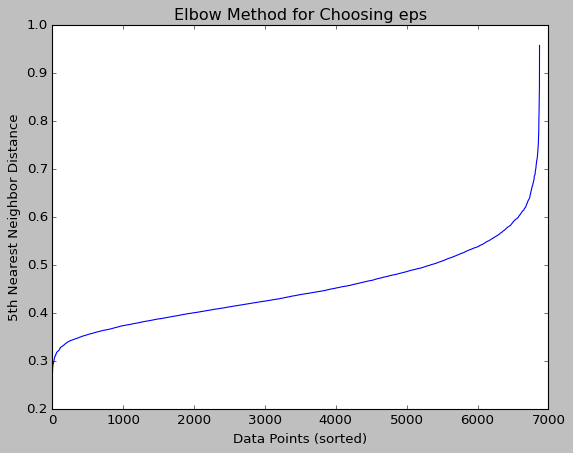

In [76]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Compute distances to 5 nearest neighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(normalized_embeddings)
distances, _ = neigh.kneighbors(normalized_embeddings)

# Sort and plot the distances
sorted_distances = np.sort(distances[:, -1])
plt.plot(sorted_distances)
plt.xlabel("Data Points (sorted)")
plt.ylabel("5th Nearest Neighbor Distance")
plt.title("Elbow Method for Choosing eps")
plt.show()

In [51]:
embeddings

array([[ 0.04783673,  0.01500032, -0.01409549, ..., -0.02312624,
         0.04516995, -0.18631609],
       [ 0.0480858 ,  0.04957828,  0.00574639, ...,  0.06402364,
         0.0247922 , -0.06253822],
       [ 0.05098445,  0.03231893, -0.01655107, ...,  0.06944688,
         0.03598671, -0.09523369],
       ...,
       [ 0.04262909,  0.02548489, -0.00226897, ...,  0.02635074,
         0.04129845, -0.0328822 ],
       [ 0.05675366,  0.04125762, -0.0084409 , ...,  0.05642366,
        -0.02194276, -0.0584268 ],
       [ 0.02101483,  0.03944277, -0.01677711, ...,  0.0806163 ,
         0.01459916, -0.0574783 ]], shape=(6876, 312), dtype=float32)

----------------

In [115]:
# --- 3. Кластеризация ---
# K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(scaled_features)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
clusters_dbscan = dbscan.fit_predict(embeddings)

# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
clusters_agglo = agglo.fit_predict(embeddings)

# --- 6. Оценка качества кластеризации ---
silhouette_kmeans = silhouette_score(embeddings, clusters_kmeans)
silhouette_agglo = silhouette_score(embeddings, clusters_agglo)

print(f"\nСилуэтный коэффициент для K-Means: {silhouette_kmeans:.4f}")
print(f"Силуэтный коэффициент для Agglomerative Clustering: {silhouette_agglo:.4f}")


Силуэтный коэффициент для K-Means: 0.3268
Силуэтный коэффициент для Agglomerative Clustering: 0.5867


In [102]:
df_init.to_parquet(project_root / "data" / "interim" / "data_with_k_means.parquet")